# Computing and using noise covariance matrices

By default, ``panco2`` will assume that the noise in the input map is white, i.e. that the noise levels in the different pixels is uncorrelated.
Since millimeter-wave observations are often affected by various sources of noise that can create correlated structures in the map (e.g. atmospheric noise, primary CMB anisotropies, etc), one may wish to take these correlations into account in the fit.
This can be done in ``panco2`` by using a noise covariance matrix in the likelihood.
``panco2`` offers several functions to compute the covariance matrix from different types of input; this notebook shows examples of how to use these functions.

We consider the C2 galaxy cluster presented in the validation paper (Keruzore et al. 2022), i.e. a fake cluster with $z=0.5, \; M_{500} = 6 \times 10^{14} M_\odot$.
As in the validation, we will look at mock realizations of the SPT $y$-maps for this cluster, using a Sanson-Flamsteed projection on a square patch of the sky with $15''$ pixels.
To make computation time faster, we only consider a $10'$ square patch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
import scipy.stats as ss
from scipy.ndimage import gaussian_filter

In [2]:
import sys
sys.path.append("..")
import panco2 as p2

Start by reading in the data, giving cluster info, and the size and center of the map to be considered for the fit:

In [3]:
path = "."
ppf = p2.PressureProfileFitter(
    f"{path}/C2_SPT.fits",
    1, 5,
    0.5, 6e14,
    map_size=10.0,
    coords_center=SkyCoord("12h00m00s +00d00m00s")
)

By default, the noise would be taken as white, with an RMS given by the map in extension 5 of the input ``FITS`` file.
To consider correlated noise, we must provide the ``PressureProfileFitter`` object with a noise covariance matrix, and/or its inverse.

## Covariance matrix from a noise power spectrum

The power spectrum of the noise in the map might be known, for example by computing it on an empty (or masked) patch of the sky.
The noise covariance matrix can be computed from this quantity by generating a large number of maps following the same power spectrum, and then evaluating the Ledoit-Wolf covariance between each map pixel pair across the realizations.
The inverse covariance matrix will then be computed as the Moore-Penrose pseudo-inverse of the covariance.

For example, using a power spectrum computed from a $5^\circ$ square patch of the minimum-variance SPT $y$-map of Bleem et al. (2022) with masked sources:

(800.0, 21000.0)

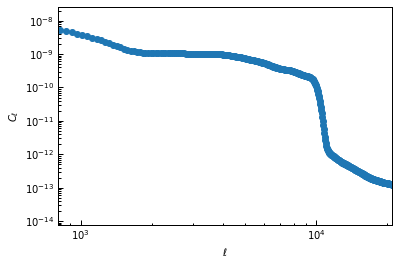

In [4]:
powspec = Table.read("./SPT_noise_powspec.csv")
fig, ax = plt.subplots()
ax.loglog(powspec["ell"], powspec["c_ell"], "o-")
ax.set_xlabel("$\ell$")
ax.set_ylabel("$C_\ell$")
ax.set_xlim(8e2, 2.1e4)

In [5]:
cov, inv_cov = p2.noise_covariance.covmat_from_powspec(powspec["ell"], powspec["c_ell"], n_pix=ppf.sz_map.shape[0], pix_size=ppf.pix_size)

/Users/fkeruzore/panco2/examples/../panco2/noise_covariance.py:96: RuntimeWarning: divide by zero encountered in log10
  filt = 10 ** filt_fct(np.log10(k_filt))


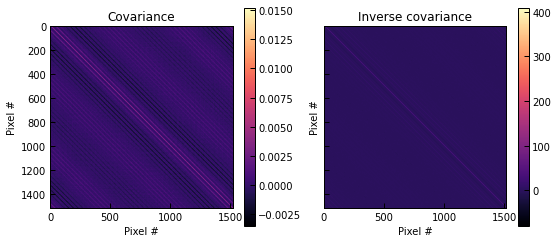

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
for m, label, ax in zip([cov, inv_cov], ["Covariance", "Inverse covariance"], axs):
    im = ax.imshow(m, cmap="magma")
    fig.colorbar(im, ax=ax)
    ax.set_title(label)
    ax.set_xlabel("Pixel #")
    ax.set_ylabel("Pixel #")

We can then provide the matrices to the `PressureProfileFitter` object through the `ppf.add_covmat` method:

In [7]:
ppf.add_covmat(covmat=cov, inv_covmat=inv_cov)

Adding correlated noise: covariance matrix & inverse


## Covariance matrix from a noise map

If one has access to a noise realization rather than its power spectrum, it can also be used to generate the covariance matrix and its inverse.
This is done by computing the power spectrum, and then using the same methodology as described above.

Using a random noise realization:

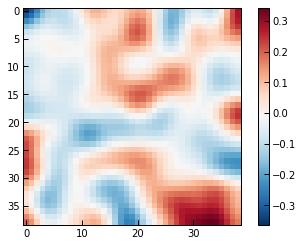

In [11]:
noise_map = gaussian_filter(np.random.normal(0.0, 1.0, ppf.sz_map.shape), 2.5)
fig, ax = plt.subplots()
im = ax.imshow(noise_map, cmap="RdBu_r")
fig.colorbar(im, ax=ax)

In [12]:
cov, inv_cov = p2.noise_covariance.covmats_from_noise_map(noise_map, pix_size=ppf.pix_size)

/Users/fkeruzore/panco2/examples/../panco2/noise_covariance.py:96: RuntimeWarning: divide by zero encountered in log10
  filt = 10 ** filt_fct(np.log10(k_filt))


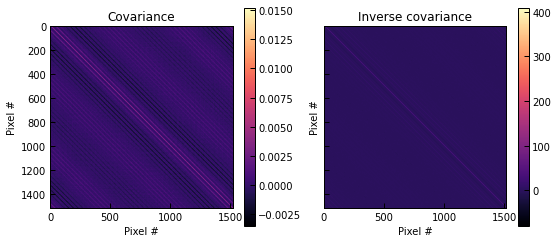

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
for m, label, ax in zip([cov, inv_cov], ["Covariance", "Inverse covariance"], axs):
    im = ax.imshow(m, cmap="magma")
    fig.colorbar(im, ax=ax)
    ax.set_title(label)
    ax.set_xlabel("Pixel #")
    ax.set_ylabel("Pixel #")

Then similarly, we can provide our `PressureProfileFitter` object with the noise covariance and its inverse:

In [16]:
ppf.add_covmat(covmat=cov, inv_covmat=inv_cov)

Adding correlated noise: covariance matrix & inverse


## Notes

* Note that the two functions to compute noise covariance matrices return both the covariance matrix and its inverse, after having ensured that the dot product of the two yielded the identity matrix.
    The `ppf.add_covmat` method can take as input either one of the two matrices, or both of them.
    If only the covariance matrix is provided, ``panco2`` will compute the pseudo-inverse to inject in the likelihood; the covariance matrix itself is not needed.

* Rather than the Ledoit-Wolf covariance, one may wish to use the sample covariance between the different noise realizations.
    This can be done by passing the ``method="np"`` keyword to the covariance matrix computation functions.
    This is not the default behavior, as sample covariance for large dimensions tend to have a large condition number and to be hard to invert numerically -- see e.g. https://scikit-learn.org/stable/auto_examples/covariance/plot_sparse_cov.html#sphx-glr-auto-examples-covariance-plot-sparse-cov-py